# **1. 데이터**

# **2. 데이터셋과 필요한 라이브러리 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

from xgboost import XGBRegressor 
from xgboost import plot_importance 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, mean_absolute_error, roc_auc_score, accuracy_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report 


In [ ]:
from sklearn.pipeline import Pipeline
import lightgbm as lgb

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"chloe18","key":"f8ed6df18b3aefeea062fca5b2ce9876"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c pubg-finish-placement-prediction

test_V2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission_V2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_V2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# 데이터셋 저장

train = pd.read_csv('/content/train_V2.csv.zip')
test = pd.read_csv('/content/test_V2.csv.zip')
sample_submit = pd.read_csv('/content/sample_submission_V2.csv.zip')

In [ ]:
train.shape, test.shape, sample_submit.shape

((4446966, 29), (1934174, 28), (1934174, 2))

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [ ]:
train.head(3)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.0,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.8,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.0,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.0,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.0,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.8,2,0,0.7755


## **Data Description**

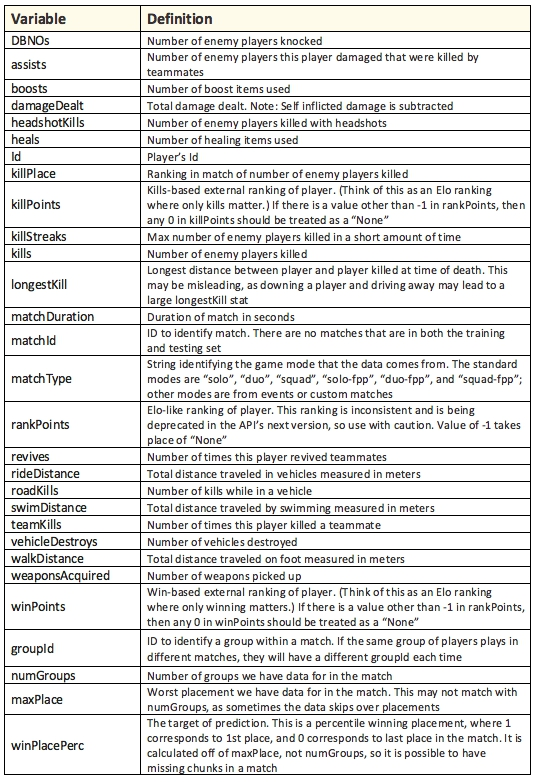

# **3. 데이터 전처리 + EDA**

## **3-1) 중복치랑 결측치 처리**

In [ ]:
train.duplicated().value_counts()

False    4446966
dtype: int64

In [ ]:
train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [ ]:
# 결측치 처리

train.dropna(inplace=True)
print(train.shape)

(4446965, 29)




---
## **3-2) 분석할 데이터만 추출**


In [ ]:
matchTypes = train.loc[:,"matchType"].value_counts().to_frame().reset_index()
matchTypes.columns = ["Type","Count"]
matchTypes

,Type,Count
0,squad-fpp,1756186
1,duo-fpp,996691
2,squad,626526
3,solo-fpp,536761
4,duo,313591
5,solo,181943
6,normal-squad-fpp,17174
7,crashfpp,6287
8,normal-duo-fpp,5489
9,flaretpp,2505


In [ ]:
mapper = lambda x: 'squad' if ('squad' in x) else 'other'
train['matchType'] = train['matchType'].apply(mapper)
test['matchType'] = test['matchType'].apply(mapper)

In [ ]:
# 'matchType'이 'squad'인 애들만 뽑아서 새로 데이터셋을 저장

train = train.loc[train['matchType']=='squad']
test = test.loc[test['matchType']=='squad']

In [ ]:
print(train.shape)
train.head()

(2400402, 29)


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad,28,26,-1,0,0.0000,0,0.00,0,0,244.8,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad,26,25,1484,0,0.0045,0,11.04,0,0,1434.0,5,0,0.6400
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad,31,30,1408,0,0.0000,0,0.00,0,0,202.7,3,0,0.1667
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.00,1,1,0,44,0,1,1,18.44,1395,squad,28,28,1418,0,0.0000,0,0.00,0,0,34.7,1,0,0.0370
6,95959be0e21ca3,2c485a1ad3d0f1,a8274e903927a2,0,0,0.00,0,0,0,96,1262,0,0,0.00,1316,squad,28,28,-1,0,0.0000,0,0.00,0,0,13.5,1,1497,0.0000


In [ ]:
print(test.shape)
test.head()

(1032314, 28)


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,0,0,0,0.00,1884,squad,28,28,1500,0,0.0,0,0.0,0,0,588.0,1,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,0,0,0,0.00,1793,squad,28,27,1565,0,0.0,0,0.0,0,0,787.8,4,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,0,3,1,60.06,1326,squad,28,27,1480,1,0.0,0,0.0,0,0,2963.0,4,0
5,3e2539b5d78183,029b5a79e08cd6,10186f5c852f62,0,0,0.00,0,0,0,89,0,0,0,0.00,1775,squad,29,29,1490,0,0.0,0,0.0,0,0,0.0,0,0
7,a8a377e4d43bf8,61ec2e7730a3b8,d31adc82a4930e,0,0,68.61,0,0,0,73,0,0,0,0.00,1870,squad,29,27,1487,0,0.0,0,0.0,0,0,1217.0,5,0



---
## **3-3) EDA + Feature Engineering**

###**Kills 컬럼**

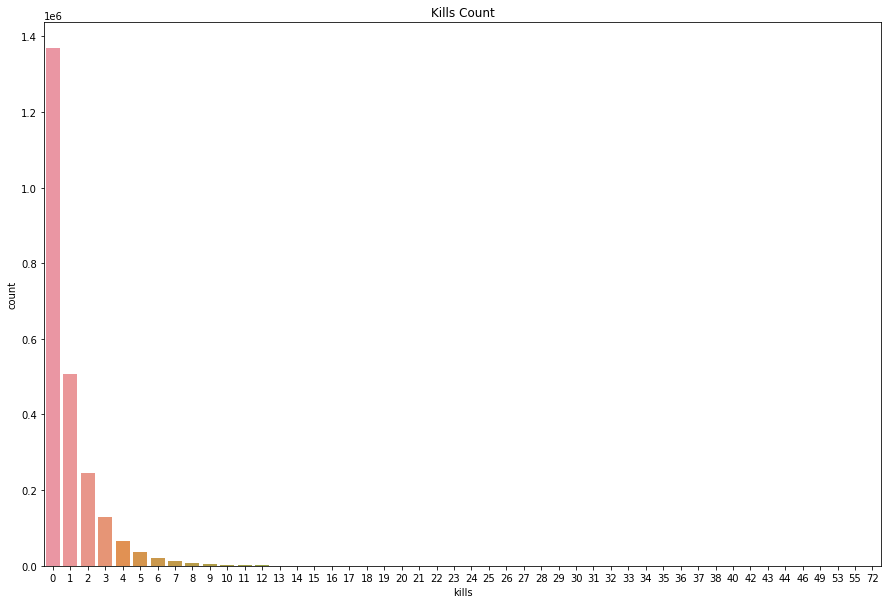

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(train['kills']);
plt.title('Kills Count')
plt.show()

* 한명도 못 죽인 플레이어들이 대다수이고, 보면 kill수가 이상하리만큼 높은 플레이어가 존재한다
* 그래서 전체의 99% 플레이어들의 평균과 맥시멈 kill수를 확인해보고자 한다

In [ ]:
print('99%의 참가자의 kill수는', train['kills'].quantile(0.99), '이하로 나타남')
print('맥시멈 kill수는', train['kills'].max())
print('평균 kill수는', train['kills'].mean())

99%의 참가자의 kill수는 7.0 이하로 나타남
맥시멈 kill수는 72
평균 kill수는 0.9206849519372172




---


### **Zombie를 확인해서 제거**

99%의 참가자의 weaponsAcquired는 11.0 이하로 나타남
맥시멈 weaponsAcquired는 236
평균 weaponsAcquired는 3.7102147890228387


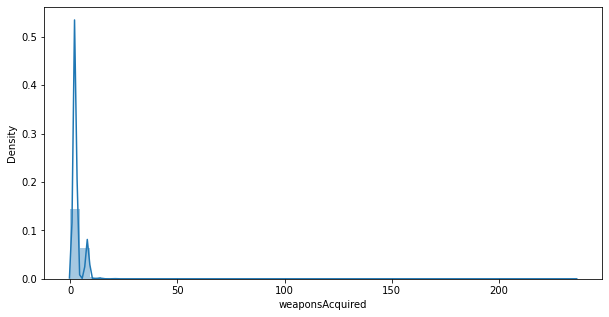

In [ ]:
# weaponsAcquired 분포를 확인

print('99%의 참가자의 weaponsAcquired는', train['weaponsAcquired'].quantile(0.99), '이하로 나타남')
print('맥시멈 weaponsAcquired는', train['weaponsAcquired'].max())
print('평균 weaponsAcquired는', train['weaponsAcquired'].mean())

plt.figure(figsize=(10,5))
sns.distplot(train['weaponsAcquired']);

99%의 참가자의 rideDistance는 7113.0 이하로 나타남
맥시멈 rideDistance는 29000.0
평균 rideDistance는 647.2753703108888


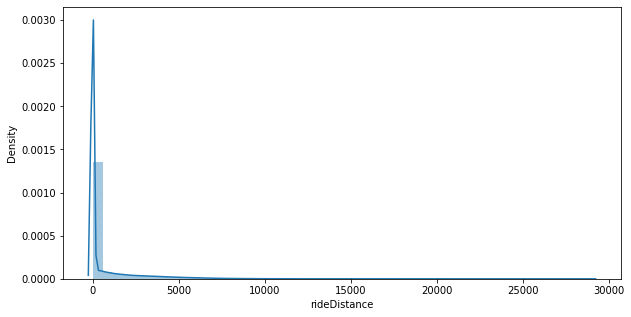

In [ ]:
# rideDistance 분포를 확인

print('99%의 참가자의 rideDistance는', train['rideDistance'].quantile(0.99), '이하로 나타남')
print('맥시멈 rideDistance는', train['rideDistance'].max())
print('평균 rideDistance는', train['rideDistance'].mean())

plt.figure(figsize=(10,5))
sns.distplot(train['rideDistance']);

In [ ]:
# Zombies Out

train = train.loc[((train.weaponsAcquired != 0) | (train.rideDistance != 0)) | ((train.teamKills == 0) & (train.kills == 0) & (train.headshotKills == 0))]
test = test.loc[((test.weaponsAcquired != 0) | (test.rideDistance != 0)) | ((test.teamKills == 0) & (test.kills == 0) & (test.headshotKills == 0))]

print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (2397058, 29)
test shape:  (1030950, 28)




---
### **필요없는 변수 정리**

In [ ]:
def preprocessing(df):

    # id 변수를 제거합니다.
    df = df.drop(columns=['matchId', 'groupId', 'Id'], axis=1)

    # 필요없는 변수를 제거합니다.
    df = df.drop('matchType', axis = 1)
    df = df.drop('numGroups', axis = 1)
    df = df.drop('maxPlace', axis = 1)

    df['noCarDistance'] = df['swimDistance'] + df['walkDistance']
    df = df.drop('swimDistance', axis = 1)
    df = df.drop('walkDistance', axis = 1)

    df['HealsBoosts'] = df['heals'] + df['boosts']   
    df = df.drop('heals', axis=1)
    df = df.drop('boosts', axis =1)

    return df

train = preprocessing(train)
test = preprocessing(test)

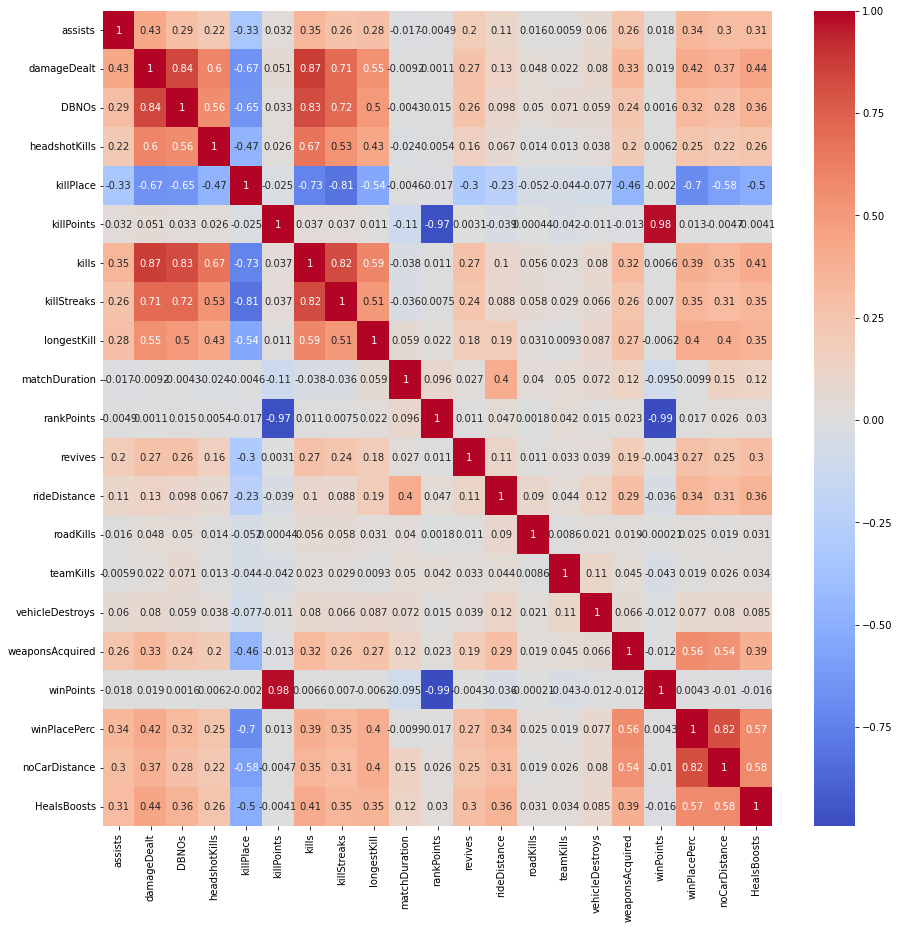

In [ ]:
# 상관관계를 히트맵으로 그려 확인해보겠습니다

corr = train.corr(method='pearson')
fig = plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap = 'coolwarm', center = 0);

In [ ]:
def preprocessing2(df):

    # 타겟값인 winPlacePerc랑 상관관계가 낮은 변수들을 제거
    df = df.drop(columns=['killPoints', 'matchDuration', 'rankPoints', 'winPoints'], axis=1)
    df = df.drop(columns=['roadKills', 'teamKills', 'vehicleDestroys'], axis=1)

    return df

train = preprocessing2(train)
test = preprocessing2(test)

print(train.shape)
print(test.shape)

(2397058, 14)
(1030950, 13)


### **이상치 제거**

In [ ]:
train.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
assists,2397058.0,0.294923,0.663202,0.0,0.0000,0.00,0.0000,17.0
damageDealt,2397058.0,134.056564,172.788773,0.0,0.0000,87.18,190.3000,5990.0
DBNOs,2397058.0,0.873938,1.320401,0.0,0.0000,0.00,1.0000,53.0
headshotKills,2397058.0,0.222662,0.595397,0.0,0.0000,0.00,0.0000,64.0
killPlace,2397058.0,47.691668,27.450428,1.0,24.0000,48.00,71.0000,101.0
kills,2397058.0,0.921391,1.557495,0.0,0.0000,0.00,1.0000,72.0
killStreaks,2397058.0,0.554975,0.739496,0.0,0.0000,0.00,1.0000,20.0
longestKill,2397058.0,23.829064,53.342531,0.0,0.0000,0.00,21.4700,1094.0
revives,2397058.0,0.217358,0.539841,0.0,0.0000,0.00,0.0000,23.0
rideDistance,2397058.0,648.178348,1543.034472,0.0,0.0000,0.00,195.9000,29000.0


Text(0.5, 1.0, 'HealsBoosts')

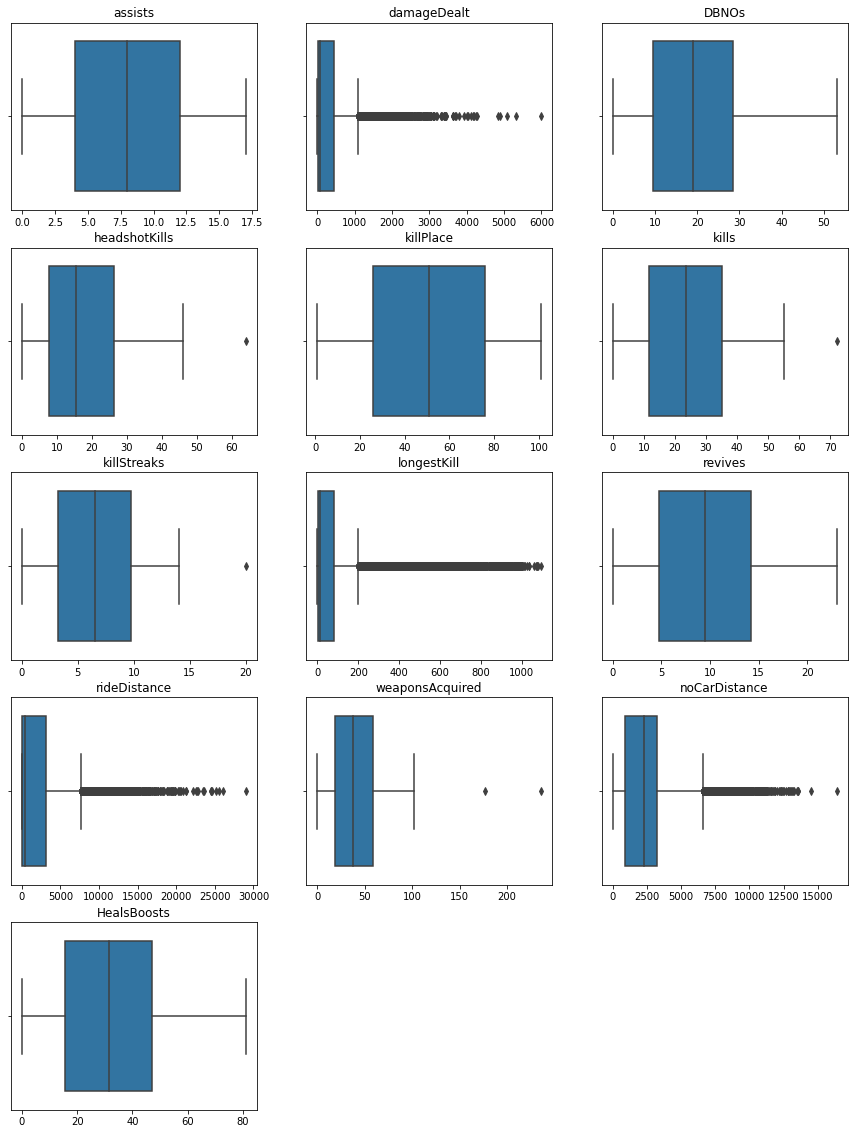

In [ ]:
plt.figure(figsize=(15,20))

plt.subplot(5,3,1)
sns.boxplot(train['assists'].unique())
plt.title('assists')

plt.subplot(5,3,2)
sns.boxplot(train['damageDealt'].unique())
plt.title('damageDealt')

plt.subplot(5,3,3)
sns.boxplot(train['DBNOs'].unique())
plt.title('DBNOs')

plt.subplot(5,3,4)
sns.boxplot(train['headshotKills'].unique())
plt.title('headshotKills')

plt.subplot(5,3,5)
sns.boxplot(train['killPlace'].unique())
plt.title('killPlace')

plt.subplot(5,3,6)
sns.boxplot(train['kills'].unique())
plt.title('kills')

plt.subplot(5,3,7)
sns.boxplot(train['killStreaks'].unique())
plt.title('killStreaks')

plt.subplot(5,3,8)
sns.boxplot(train['longestKill'].unique())
plt.title('longestKill')

plt.subplot(5,3,9)
sns.boxplot(train['revives'].unique())
plt.title('revives')

plt.subplot(5,3,10)
sns.boxplot(train['rideDistance'].unique())
plt.title('rideDistance')

plt.subplot(5,3,11)
sns.boxplot(train['weaponsAcquired'].unique())
plt.title('weaponsAcquired')

plt.subplot(5,3,12)
sns.boxplot(train['noCarDistance'].unique())
plt.title('noCarDistance')

plt.subplot(5,3,13)
sns.boxplot(train['HealsBoosts'].unique())
plt.title('HealsBoosts')

In [ ]:
def remove_outlier(df, col): 
  q1, q3 = np.quantile(df[col], 0.25), np.quantile(df[col], 0.75)             
  iqr = q3 - q1       
  lower, upper = q1 - (iqr * 1.5), q3 + (iqr * 1.5)   
  
  removed = df[df[col].between(lower, upper)]

  return removed

In [ ]:
train = remove_outlier(train, 'damageDealt')
train = remove_outlier(train, 'longestKill')
train = remove_outlier(train, 'weaponsAcquired')
train = remove_outlier(train, 'noCarDistance')

train.shape

(1902141, 14)

In [ ]:
test = remove_outlier(test, 'damageDealt')
test = remove_outlier(test, 'longestKill')
test = remove_outlier(test, 'weaponsAcquired')
test = remove_outlier(test, 'noCarDistance')

test.shape

(818845, 13)

Text(0.5, 1.0, 'HealsBoosts')

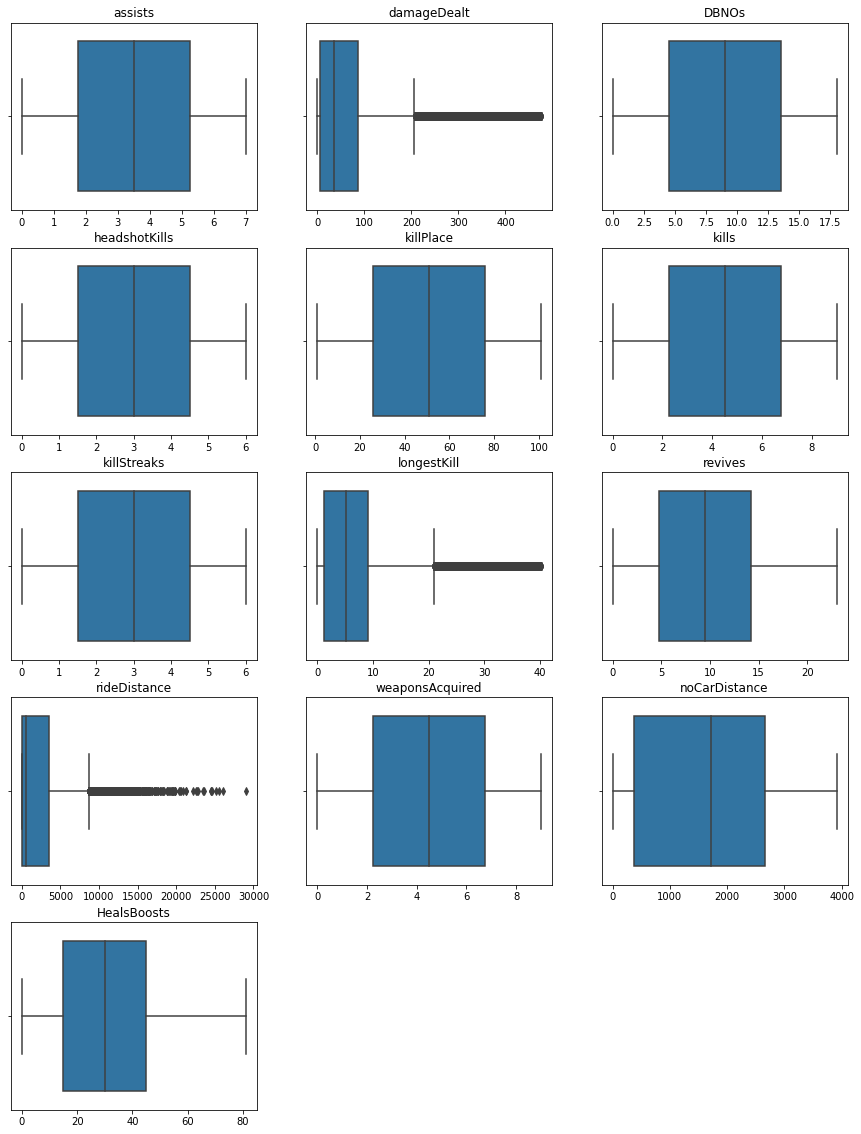

In [ ]:
plt.figure(figsize=(15,20))

plt.subplot(5,3,1)
sns.boxplot(train['assists'].unique())
plt.title('assists')

plt.subplot(5,3,2)
sns.boxplot(train['damageDealt'].unique())
plt.title('damageDealt')

plt.subplot(5,3,3)
sns.boxplot(train['DBNOs'].unique())
plt.title('DBNOs')

plt.subplot(5,3,4)
sns.boxplot(train['headshotKills'].unique())
plt.title('headshotKills')

plt.subplot(5,3,5)
sns.boxplot(train['killPlace'].unique())
plt.title('killPlace')

plt.subplot(5,3,6)
sns.boxplot(train['kills'].unique())
plt.title('kills')

plt.subplot(5,3,7)
sns.boxplot(train['killStreaks'].unique())
plt.title('killStreaks')

plt.subplot(5,3,8)
sns.boxplot(train['longestKill'].unique())
plt.title('longestKill')

plt.subplot(5,3,9)
sns.boxplot(train['revives'].unique())
plt.title('revives')

plt.subplot(5,3,10)
sns.boxplot(train['rideDistance'].unique())
plt.title('rideDistance')

plt.subplot(5,3,11)
sns.boxplot(train['weaponsAcquired'].unique())
plt.title('weaponsAcquired')

plt.subplot(5,3,12)
sns.boxplot(train['noCarDistance'].unique())
plt.title('noCarDistance')

plt.subplot(5,3,13)
sns.boxplot(train['HealsBoosts'].unique())
plt.title('HealsBoosts')

In [ ]:
# 99%를 기준으로 이상치 제거

def remove_outlier99(df, col):
  df = df.loc[df[col] < (df[col].quantile(0.99)+1)]
  return df

train = remove_outlier99(train, 'rideDistance')
test = remove_outlier99(test, 'rideDistance')

In [ ]:
train.shape, test.shape

((1883123, 14), (810660, 13))

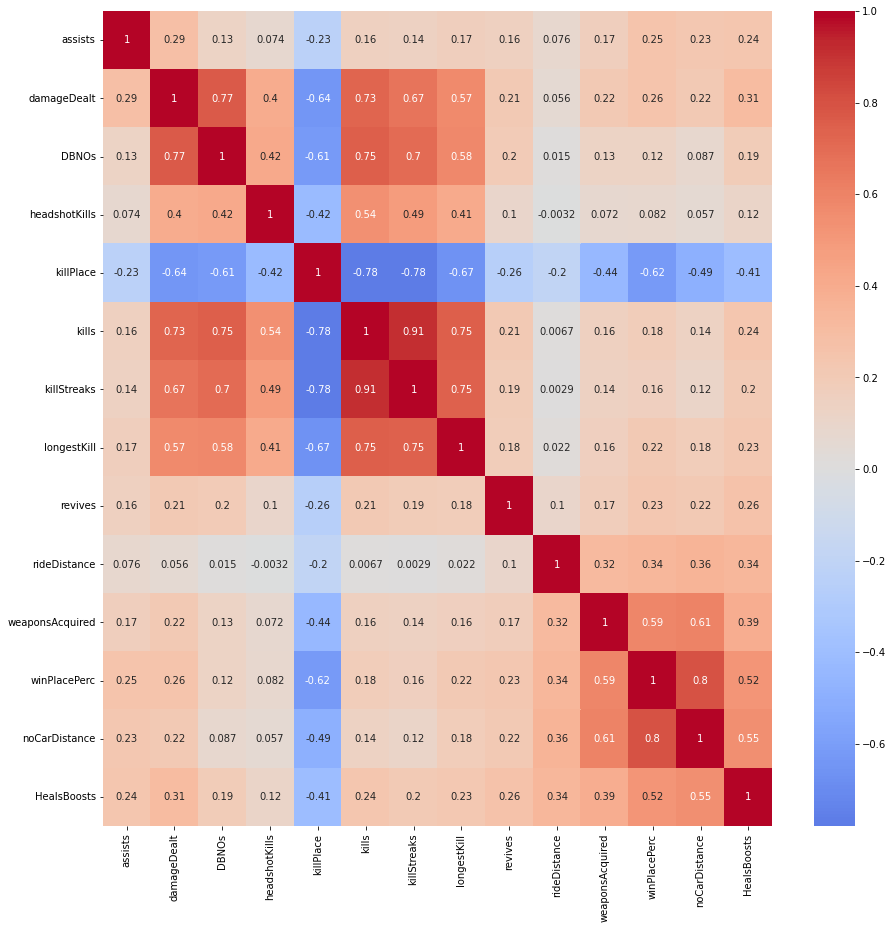

In [ ]:
# 상관관계를 히트맵으로 그려 확인해보겠습니다

corr = train.corr(method='pearson')
fig = plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap = 'coolwarm', center = 0);

# **4. 모델링**

## **4-1) 데이터셋 나누기**

In [ ]:
train, val = train_test_split(train, train_size=0.7, test_size=0.3, random_state=2)

target = 'winPlacePerc'
X_train = train.drop(target, axis=1)
X_val = val.drop(target, axis=1)

y_train = train[target]
y_val = val[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1318186, 13), (1318186,), (564937, 13), (564937,))

## **4-2) 기준모델 설정**

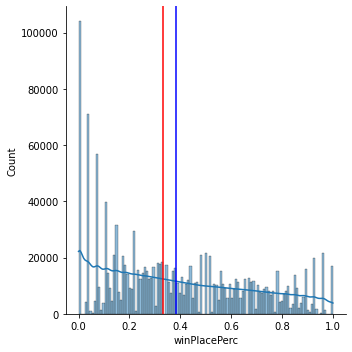

In [ ]:
# winPlacePerc의 확률밀도함수를 그려보겠습니다
sns.displot(train['winPlacePerc'], kde=True);

# 평균과, 중간값으로 수직선을 그려보겠습니다.
plt.axvline(train['winPlacePerc'].mean(), color='blue');
plt.axvline(train['winPlacePerc'].median(), color='red');

In [ ]:
#회귀 문제이므로 평균값을 기준모델로 사용

y_pred=[y_train.mean()]*len(y_train)
mae=mean_absolute_error(y_train,y_pred)
print('Baseline MAE:',mae)

Baseline MAE: 0.24568085773156648


## **4-3) XGB모델링**

In [ ]:
model_xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.2,
    random_state=2,
    max_depth=10,
    n_jobs=-1
)

eval_set = [(X_train, y_train), 
            (X_val, y_val)]

model_xgb.fit(X_train, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=50
         )

[17:56:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.25518	validation_1-rmse:0.255259
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.213343	validation_1-rmse:0.21347
[2]	validation_0-rmse:0.181329	validation_1-rmse:0.181563
[3]	validation_0-rmse:0.157523	validation_1-rmse:0.157845
[4]	validation_0-rmse:0.139948	validation_1-rmse:0.1404
[5]	validation_0-rmse:0.127464	validation_1-rmse:0.128027
[6]	validation_0-rmse:0.118671	validation_1-rmse:0.119337
[7]	validation_0-rmse:0.112583	validation_1-rmse:0.113346
[8]	validation_0-rmse:0.108415	validation_1-rmse:0.109291
[9]	validation_0-rmse:0.105575	validation_1-rmse:0.106559
[10]	validation_0-rmse:0.103695	validation_1-rmse:0.104776
[11]	validation_0-rmse:0.102392	validation_1-rmse:0.103566
[12]	validation_0-rm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=2,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
print('훈련 정확도:', model_xgb.score(X_train,y_train))
print('검증 정확도:', model_xgb.score(X_val,y_val))

훈련 정확도: 0.8840387866799653
검증 정확도: 0.8765630361946124


## **4-4) LightGBM 모델링**

In [ ]:
pipe_lgb = Pipeline([
    ('preprocessing', make_pipeline(SimpleImputer())),
    ('lgb', lgb.LGBMRegressor(n_estimators=400,
                              random_state=2,
                              n_jobs=-1,
                              learning_rate=0.2))
])

pipe_lgb.fit(X_train, y_train)
pred = pipe_lgb.predict(X_val)

mae = mean_absolute_error(y_val, pred)

print('mae: ', mae)

mae:  0.07257733453653017


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, ShuffleSplit
from scipy.stats import randint

dists = {  
    'lgb__LGBMRegressor__n_estimators': randint(100, 400, 1000),
    'lgb__LGBMRegressor__num_leaves': randint(1, 100),
    'lgb__LGBMRegressor__min_data_in_leaf': randint(100, 1000),
    'lgb__LGBMRegressor__max_depth': randint(1, 15)    
}

clf = RandomizedSearchCV(
    pipe_lgb, 
    param_distributions=dists, 
    n_iter=100, 
    cv=ShuffleSplit(n_splits=1), 
    scoring='neg_root_mean_squared_error',  
    
    verbose=2,
    n_jobs=-1
)
clf.fit(X_train, y_train)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 43.3min finished


RandomizedSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=None, train_size=None),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessing',
                                              Pipeline(memory=None,
                                                       steps=[('simpleimputer',
                                                               SimpleImputer(add_indicator=False,
                                                                             copy=True,
                                                                             fill_value=None,
                                                                             missing_values=nan,
                                                                             strategy='mean',
                                                                             verbose=0))],
                                        

In [ ]:
clf.best_params_

{'lgb__LGBMRegressor__max_depth': 2,
 'lgb__LGBMRegressor__min_data_in_leaf': 945,
 'lgb__LGBMRegressor__n_estimators': 1244,
 'lgb__LGBMRegressor__num_leaves': 41}

In [ ]:
-clf.best_score_

0.10063957445977356

In [ ]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score', ascending=False).T

,0,63,73,72,71,70,69,68,67,66,65,64,62,1,61,60,59,58,57,56,55,54,53,52,74,75,76,77,98,97,96,95,94,93,92,91,90,89,88,87,...,15,14,13,12,11,10,9,8,7,6,5,4,3,2,23,25,48,26,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,99
mean_fit_time,52.1519,42.549,42.8014,42.9318,42.7447,42.7424,42.4286,42.7958,42.8441,43.0815,42.6271,42.6084,42.5845,52.6869,42.3277,42.5618,43.0825,43.0747,43.3512,43.4427,44.503,44.5059,43.9829,44.2217,42.6144,42.4952,43.1018,43.1943,43.4516,43.3314,43.4726,43.3122,43.288,43.5536,43.9238,44.1232,44.2257,46.9302,47.1977,46.9618,...,52.3668,52.7831,53.7057,53.6298,68.8953,69.6044,71.1026,70.3545,67.785,67.8061,61.936,62.1711,55.1861,55.3555,51.4526,50.1479,43.7217,51.1894,50.0827,50.2791,50.0772,49.5046,47.209,47.1319,50.9762,51.194,50.5258,50.7729,55.7358,55.8005,55.4666,55.7081,49.2907,48.8473,48.5858,48.543,48.6875,48.6315,51.122,42.5645
std_fit_time,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
mean_score_time,3.18593,2.90439,2.91843,2.7522,2.97963,2.80771,2.90936,2.8103,2.92148,2.78426,2.8787,2.7993,2.77246,3.36411,2.88021,2.75736,2.99092,2.82611,2.97284,2.85201,2.95107,2.81432,2.9394,2.83471,2.7128,2.8824,2.80141,2.91546,2.8312,2.97429,2.80794,2.86921,2.80126,2.89209,2.87512,2.96756,2.79965,2.85847,2.79775,2.94822,...,3.5465,3.49029,3.61631,3.64139,3.44576,3.50811,4.53087,4.24716,4.52578,4.38402,3.72308,3.55932,3.94852,3.84467,3.52435,3.52362,2.86268,3.25726,2.89887,2.85527,3.40628,3.32397,3.19949,2.89538,3.167,3.03771,3.17824,3.14332,3.72219,3.77641,3.95048,3.57907,3.95386,3.77132,3.42059,3.19908,3.3739,3.22965,3.30454,2.11872
std_score_time,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
param_lgb__LGBMRegressor__max_depth,2,14,5,7,10,8,11,3,7,9,8,4,8,13,12,12,14,9,6,9,7,5,12,11,8,4,11,4,9,3,6,12,6,7,12,11,8,6,10,9,...,9,7,5,5,1,14,8,2,2,6,10,3,11,14,13,8,7,7,7,7,11,10,9,13,11,4,3,9,4,7,8,9,8,2,11,10,14,5,7,2
param_lgb__LGBMRegressor__min_data_in_leaf,945,522,966,607,435,625,208,720,185,500,423,617,212,732,144,194,904,524,566,572,499,176,918,209,913,636,610,824,357,327,132,642,286,140,788,928,361,433,322,369,...,198,736,836,217,446,472,989,742,794,260,686,630,155,949,780,417,596,769,773,751,711,952,768,484,892,547,164,928,705,282,221,791,281,767,347,192,617,207,319,148
param_lgb__LGBMRegressor__n_estimators,1244,1201,1179,1108,1211,1282,1372,1137,1305,1193,1204,1238,1202,1345,1288,1219,1212,1387,1307,1224,1232,1244,1362,1357,1175,1367,1311,1374,1275,1327,1151,1344,1370,1258,1105,1137,1166,1105,1310,1182,...,1164,1197,1295,1133,1343,1364,1372,1323,1390,1163,1328,1173,1396,1221,1234,1208,1263,1284,1119,1196,1359,1346,1337,1226,1151,1141,1385,1298,1391,1339,1157,1273,1259,1211,1115,1282,1332,1266,1339,1156
param_lgb__LGBMRegressor__num_leaves,41,93,34,48,64,64,59,52,37,62,15,47,82,94,57,13,38,8,46,76,18,27,15,98,87,16,31,19,25,20,12,74,22,16,83,55,65,29,35,18,...,45,99,90,78,82,6,23,24,29,72,85,23,45,3,47,44,36,57,79,61,87,54,70,40,18,8,73,20,47,94,98,65,98,63,54,95,20,23,88,5
params,"{'lgb__LGBMRegressor__max_depth': 2, 'lgb__LGB...","{'lgb__LGBMRegressor__max_depth': 14, 'lgb__LG...","{'lgb__LGBMRegressor__max_depth': 5, 'lgb__LGB...","{'lgb__LGBMRegressor__max_depth': 7, 'lgb__LGB...","{'lgb__LGBMRegressor__max_depth': 10, 'lgb__LG...","{'lgb__LGBMRegressor__max_depth': 8, 'lgb__LGB...","{'lgb__LGBMRegressor__max_depth': 11, 'lgb__LG...","{'lgb__LGBMRegressor__max_depth': 3, 'lgb__LGB...","{'lgb__LGBMRegressor__max_depth': 7, 'lgb__LGB...","{'lgb__LGBMRegressor__max_depth': 9, 'lgb__LGB...","{'lgb__LGBMRegressor__max_depth': 8, 'lgb__LGB...","{'lgb__LGBMRegressor__max_depth': 4, 'lgb__LGB...","{'lgb__LGBMRegressor__max_depth': 8, 'lgb__LGB...","{'lgb__LGBMRegressor__max_depth': 13, 'lgb__LG...","{'lgb__LGBMRegressor__max_depth': 12, 'lgb__LG...","{'lgb__LGBMR

In [ ]:
best_e = clf.best_estimator_
y_pred = best_e.predict(X_val)

In [ ]:
mae = mean_absolute_error(y_val, y_pred)
print('mae: ', mae)

mae:  0.07257733453653017
